In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc
from neurorient.reconstruction.phasing import PhaseRetriever

import h5py
from pytorch3d.transforms import matrix_to_quaternion

In [2]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

ckpt_path = '/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_14754479/checkpoints/last.ckpt'

In [3]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model'
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [4]:
# model = NeurOrient.load_from_checkpoint(
#     os.path.join(model_dir, 'lightning_logs/version_14504328/checkpoints/last.ckpt'))

model = NeurOrient.load_from_checkpoint(ckpt_path)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [6]:
dataset = TensorDataset(spi_data['intensities'].unsqueeze(1))
dataloader = DataLoader(dataset, batch_size=50, shuffle=False)

In [7]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions

orientations_pred = []

with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        slices_target = torch.log(1. + batch[0]).to(device)
        orientations = matrix_to_quaternion(model.image_to_orientation(slices_target)).cpu()
        orientations_pred.append(orientations)

orientations_pred = torch.cat(orientations_pred)

100%|██████████| 200/200 [00:03<00:00, 51.54it/s] 


In [8]:
import numpy as np

grid_reciprocal = model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(np.pi * grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1) / 10

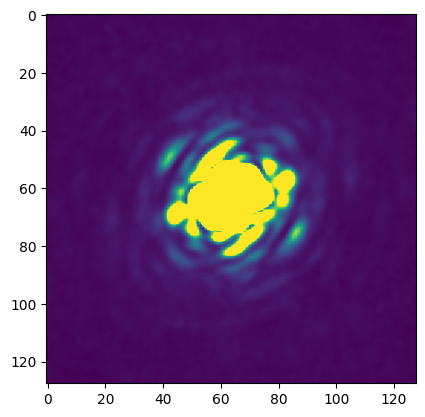

In [9]:
plt.imshow(intensity_pred[64].detach().cpu().numpy(), vmax=.3)

In [10]:
phase_retriever = PhaseRetriever(n_phase_loops=10, beta=0.9)
rho_phased, support_phased = phase_retriever.phase(intensity_pred.clip(0).sqrt())

Phase Retrieval: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


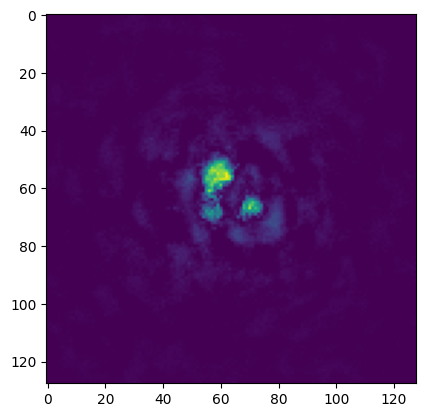

In [11]:
plt.imshow(rho_phased[64].detach().cpu().clip(0))

In [12]:
save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())

In [13]:
# intensities = torch.fft.fftshift(torch.fft.fftn(rho_phased)).abs().pow(2)
ac = torch.fft.ifftshift(torch.fft.ifftn(intensity_pred).abs()).detach().cpu()

In [14]:
h5_fpath = os.path.join(
    save_dir, 
    f'{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000}K_netPrior.h5')
with h5py.File(h5_fpath, 'w') as f:
    f.create_dataset('intensities', data=spi_data['intensities'].unsqueeze(1).numpy())
    f.create_dataset('orientations', data=orientations_pred.numpy())
    f.create_dataset('ac', data=ac.numpy())
    f.create_dataset('grid_position_real', data=model.grid_position_real.cpu().numpy())
    f.create_dataset('pixel_position_reciprocal', data=spi_data['pixel_position_reciprocal'].numpy())
    f.create_dataset('pixel_distance_reciprocal', data=spi_data['pixel_position_reciprocal'].norm(dim=-1).numpy())
    f.create_dataset('pixel_index_map', data=spi_data['pixel_index_map'].numpy())
print("data wrote to: \n", h5_fpath)

data wrote to: 
 /pscratch/sd/z/zhantao/neurorient_repo/data/1BXR_increase10_poissonTrue_num10K_netPrior.h5
